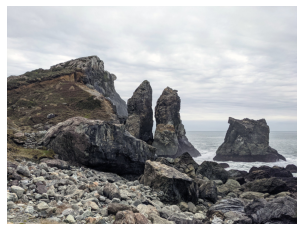

In [45]:
#from tensorflow import keras
import matplotlib.pyplot as plt

#import keras.utils as image
#import tensorflow as tf

#from keras.utils import load_img, img_to_array
#from tensorflow.keras.utils import load_img
from keras_preprocessing.image import load_img

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(load_img(base_image_path))

In [46]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [47]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [48]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [49]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [50]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [59]:
import numpy as np

#import keras.utils as image
#from keras.utils import load_img, img_to_array
#from keras.utils import load_img, img_to_array

from keras.preprocessing import image

def preprocess_image(image_path):

    #img = tf.keras.utils.load_img(image_path)
    
    
    img = image.load_img(image_path)
    img = image.img_to_array(img)

    #img = keras.utils.load_img(image_path)
    #img = keras.utils.img_to_array(img)

    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [61]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

image.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.51
... Loss value at step 6: 2.86
... Loss value at step 7: 3.19
... Loss value at step 8: 3.54
... Loss value at step 9: 3.92
... Loss value at step 10: 4.28
... Loss value at step 11: 4.62
... Loss value at step 12: 5.02
... Loss value at step 13: 5.36
... Loss value at step 14: 5.75
... Loss value at step 15: 6.14
... Loss value at step 16: 6.47
... Loss value at step 17: 6.82
... Loss value at step 18: 7.13
... Loss value at step 19: 7.47
... Loss value at step 20: 7.81
... Loss value at step 21: 8.12
... Loss value at step 22: 8.42
... Loss value at step 23: 8.69
... Loss value at step 24: 8.99
... Loss value at step 25: 9.26
... Loss value at step 26: 9.51
... Loss value at step 27: 9.83
... Loss value at step 28: 10.06
... Loss value at step 29: 10.33
Proces

<function matplotlib.pyplot.show(close=None, block=None)>

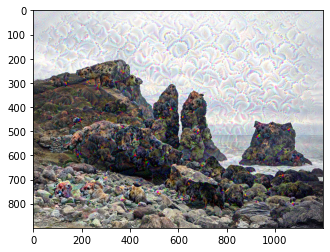

In [62]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("dream.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show